<a href="https://colab.research.google.com/github/mdrk300902/demo-repo/blob/main/CycleGAN_Translating_(Horses__Zebras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CycleGAN: Horse to Zebra Image Translation Project

This project implements a **Cycle-Consistent Generative Adversarial Network (CycleGAN)** to perform unpaired image-to-image translation between horses and zebras using the [Horse2Zebra dataset](https://efrosgans.eecs.berkeley.edu/cyclegan/datasets//).


## Project Overview

- **Goal:** Automatically transform images of horses into realistic zebra images, and vice versa, without requiring paired training data.
- **Dataset:** Contains unpaired images of horses and zebras split into training and test sets.
- **Model:** CycleGAN architecture consisting of two generators and two discriminators.
  - Generators learn to translate images between the two domains.
  - Discriminators distinguish real from fake images in each domain.
  - Cycle-consistency loss ensures the mapping preserves content.
- **Key Techniques:**
  - Residual blocks in the generators for deeper representation learning.
  - Identity loss to preserve color and style.
  - Replay buffers to stabilize discriminator training.
- **Training Setup:**
  - Images resized to 256×256 pixels.
  - Models trained for multiple epochs with adversarial, cycle, and identity loss components.
  - GPU acceleration utilized for efficient training.
- **Outputs:**
  - Generated images demonstrating successful translation between horse and zebra domains.
  - Model checkpoints saved for later inference or further training.
  - Training loss curves for monitoring GAN and cycle consistency convergence.




Upload the dataser zip file from local machine

In [1]:
from google.colab import files
uploaded = files.upload()

Saving horse2zebra.zip to horse2zebra.zip


Extract zip file

In [2]:
import zipfile
with zipfile.ZipFile('horse2zebra.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/horse2zebra')
print("Dataset extracted successfully!")

Dataset extracted successfully!


Set Path

In [3]:
dataset_path = '/content/horse2zebra'

## Install required libraries

In [4]:
!pip install torch torchvision plotly tqdm Pillow

# Imports
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
from tqdm.notebook import tqdm
import random
import itertools

##Setting Model specs

In [5]:
dataset_path = '/content/horse2zebra/horse2zebra'
batch_size = 4
lr = 0.0001
b1 = 0.5
b2 = 0.999
img_height = 256
img_width = 256
channels = 3
n_residual_blocks = 9
lambda_cyc = 10.0
lambda_id = 5.0
n_epochs = 20
epoch_start = 0

## Create necessary folders

In [7]:
import os
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

## Utility functions and classes

In [8]:
def to_rgb(image):
    if image.mode != "RGB":
        rgb_image = Image.new("RGB", image.size)
        rgb_image.paste(image)
        return rgb_image
    return image

class ReplayBuffer():
    def __init__(self, max_size=50):
        assert max_size > 0
        self.max_size = max_size
        self.data = []
    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.files_A = sorted(os.listdir(os.path.join(root, f"{mode}A")))
        self.files_B = sorted(os.listdir(os.path.join(root, f"{mode}B")))
        self.root = root
        self.mode = mode
    def __getitem__(self, index):
        path_A = os.path.join(self.root, f"{self.mode}A", self.files_A[index % len(self.files_A)])
        image_A = to_rgb(Image.open(path_A))
        if self.unaligned:
            path_B = os.path.join(self.root, f"{self.mode}B", self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            path_B = os.path.join(self.root, f"{self.mode}B", self.files_B[index % len(self.files_B)])
        image_B = to_rgb(Image.open(path_B))
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


## Image transformations


In [9]:
transforms_ = [
    transforms.Resize(int(img_height * 1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

## Data loaders

In [10]:
train_dataloader = DataLoader(
    ImageDataset(dataset_path, transforms_=transforms_, unaligned=True, mode="train"),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

test_dataloader = DataLoader(
    ImageDataset(dataset_path, transforms_=transforms_, unaligned=True, mode="test"),
    batch_size=1,
    shuffle=True,
    num_workers=1,
)


## Model and layer definitions

In [11]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )
    def forward(self, x):
        return x + self.block(x)

class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()
        channels = input_shape[0]
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        channels, height, width = input_shape
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
    def forward(self, img):
        return self.model(img)

## Initialize models on device

In [13]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_shape = (channels, img_height, img_width)
G_AB = GeneratorResNet(input_shape, n_residual_blocks).to(device)
G_BA = GeneratorResNet(input_shape, n_residual_blocks).to(device)
D_A = Discriminator(input_shape).to(device)
D_B = Discriminator(input_shape).to(device)

if epoch_start == 0:
    G_AB.apply(weights_init_normal)
    G_BA.apply(weights_init_normal)
    D_A.apply(weights_init_normal)
    D_B.apply(weights_init_normal)
else:
    pretrained_path = '/content/cyclegan-translating-horses-zebras-pytorch/saved_models'
    G_AB.load_state_dict(torch.load(f"{pretrained_path}/G_AB.pth"))
    G_BA.load_state_dict(torch.load(f"{pretrained_path}/G_BA.pth"))
    D_A.load_state_dict(torch.load(f"{pretrained_path}/D_A.pth"))
    D_B.load_state_dict(torch.load(f"{pretrained_path}/D_B.pth"))


## Loss functions on device

In [14]:
criterion_GAN = nn.MSELoss().to(device)
criterion_cycle = nn.L1Loss().to(device)
criterion_identity = nn.L1Loss().to(device)

## Optimizers

In [15]:
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

## Replay buffers to stores previously generated images

In [16]:
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

##Training the model

In [ ]:
for epoch in range(epoch_start, n_epochs):
    G_losses = {'identity': 0, 'gan': 0, 'cycle': 0, 'total': 0}
    D_losses = {'D_A': 0, 'D_B': 0, 'total': 0}
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{n_epochs}")
    for i, batch in enumerate(loop):
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)
        valid = torch.ones((real_A.size(0), *D_A.output_shape), requires_grad=False).to(device)
        fake = torch.zeros((real_A.size(0), *D_A.output_shape), requires_grad=False).to(device)

        # Generator forward
        optimizer_G.zero_grad()

        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2

        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        loss_G = lambda_id * loss_identity + loss_GAN + lambda_cyc * loss_cycle

        loss_G.backward()
        optimizer_G.step()

        # Discriminator A
        optimizer_D_A.zero_grad()
        loss_real = criterion_GAN(D_A(real_A), valid)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        loss_D_A.backward()
        optimizer_D_A.step()

        # Discriminator B
        optimizer_D_B.zero_grad()
        loss_real = criterion_GAN(D_B(real_B), valid)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2

        # Update losses for progress bar
        G_losses['identity'] += loss_identity.item()
        G_losses['gan'] += loss_GAN.item()
        G_losses['cycle'] += loss_cycle.item()
        G_losses['total'] += loss_G.item()
        D_losses['D_A'] += loss_D_A.item()
        D_losses['D_B'] += loss_D_B.item()
        D_losses['total'] += loss_D.item()

        loop.set_postfix(
            G_total=G_losses['total'] / (i+1),
            G_identity=G_losses['identity'] / (i+1),
            G_GAN=G_losses['gan'] / (i+1),
            G_cycle=G_losses['cycle'] / (i+1),
            D_total=D_losses['total'] / (i+1),
            D_A=D_losses['D_A'] / (i+1),
            D_B=D_losses['D_B'] / (i+1),
        )

    # Save models after each epoch
    torch.save(G_AB.state_dict(), "saved_models/G_AB.pth")
    torch.save(G_BA.state_dict(), "saved_models/G_BA.pth")
    torch.save(D_A.state_dict(), "saved_models/D_A.pth")
    torch.save(D_B.state_dict(), "saved_models/D_B.pth")

print("Training complete!")

In [20]:
print("Training complete!")

Training complete!


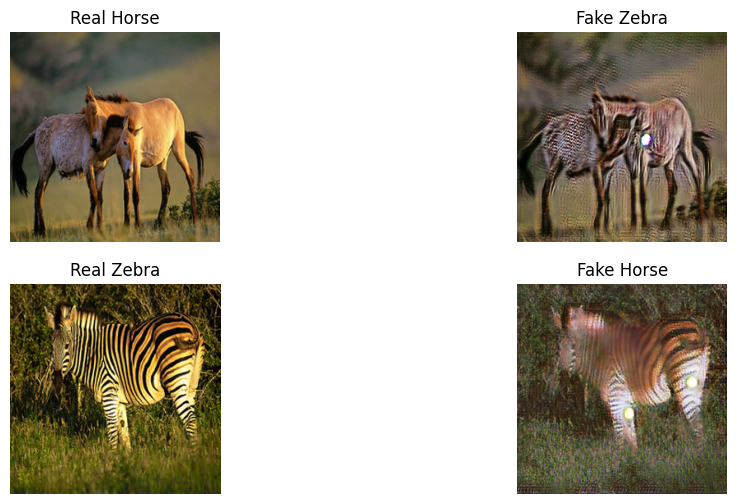

In [19]:
import matplotlib.pyplot as plt

G_AB.eval()
G_BA.eval()

test_iter = iter(test_dataloader)
samples = next(test_iter)

real_A = samples['A'].to(device)
real_B = samples['B'].to(device)

with torch.no_grad():
    fake_B = G_AB(real_A)
    fake_A = G_BA(real_B)

def imshow(tensor, title=None):
    img = tensor.cpu().detach()
    img = (img * 0.5) + 0.5  # unnormalize
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    if title:
        plt.title(title)
    plt.axis('off')

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
imshow(real_A[0], "Real Horse")
plt.subplot(2, 2, 2)
imshow(fake_B[0], "Fake Zebra")
plt.subplot(2, 2, 3)
imshow(real_B[0], "Real Zebra")
plt.subplot(2, 2, 4)
imshow(fake_A[0], "Fake Horse")
plt.show()

Due to free GPU limitations in Colab, only 20 epochs were run in place of 60 and thus the poor results.


## Insights and Potential Applications

- CycleGAN enables **unpaired image translation** enabling style transfer without needing exact image pairs.
- Useful in areas like **photo enhancement, domain adaptation, and artistic style transfer**.
- Demonstrates powerful adversarial training mechanisms with cycle consistency constraints to maintain image content.
- Highlights challenges of GAN training including mode collapse and balancing discriminator/generator loss.
- Provides a foundation to extend to other domains like seasons, horse breeds, or object transfiguration.

